In [1]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle

In [2]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

In [7]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
ens_crf_db_name   = 'ensemble_crf_cv_db_all'
ens_lg_db_name = 'ensemble_lg_cv_db_all'
cv_crf_bert_name = 'cv_crf_bert_all'
per_par=True
seq_len=3
step=3

### Open db that hold prediction

In [17]:
imp.reload(common_utils)
ens_crf_db=common_utils.load_db(dir_name,ens_crf_db_name)
ens_crf_db

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ensemble_crf_cv_db_all.csv,  index False


,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,not_nar,0.863348,0.136652,4,0,not_nar
1,not_nar,0.869768,0.130232,4,0,not_nar
2,not_nar,0.861296,0.138704,4,0,not_nar
3,not_nar,0.831258,0.168742,4,0,not_nar
4,not_nar,0.792367,0.207633,4,0,not_nar
...,...,...,...,...,...,...
38776,not_nar,0.983398,0.016602,79,9,not_nar
38777,not_nar,0.979613,0.020387,79,9,not_nar
38778,not_nar,0.969305,0.030695,79,9,not_nar
38779,not_nar,0.912650,0.087350,79,9,not_nar


### Create db to get par idx per sentence

In [18]:
sent_db =  common_utils.concat_dbs(dir_name,"sent_db",['par_idx_in_doc','sent_idx_in_par'])
sent_db

,doc_idx,sent_idx,par_idx_in_doc,sent_idx_in_par
0,1,0,0.0,0
1,1,1,1.0,0
2,1,2,2.0,0
3,1,3,3.0,0
4,1,4,4.0,0
...,...,...,...,...
38776,80,525,222.0,3
38777,80,526,222.0,4
38778,80,527,222.0,5
38779,80,528,223.0,0


In [6]:
common_utils.save_db(sent_db,dir_name,"sent_par_idx")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/sent_par_idx.csv,  index False


### Add sent index to prediction db

In [23]:
ens_crf_db['ens_sent_idx']=ens_crf_db.groupby('ens_group').cumcount()

### Add paragraph info to prediction db

In [25]:
db=ens_crf_db.merge(sent_db,left_on=['ens_group','ens_sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')

In [26]:
db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_sent_idx,doc_idx,sent_idx,par_idx_in_doc,sent_idx_in_par
0,not_nar,0.863348,0.136652,4,0,not_nar,0,4,0,0.0,0
1,not_nar,0.869768,0.130232,4,0,not_nar,1,4,1,1.0,0
2,not_nar,0.861296,0.138704,4,0,not_nar,2,4,2,2.0,0
3,not_nar,0.831258,0.168742,4,0,not_nar,3,4,3,3.0,0
4,not_nar,0.792367,0.207633,4,0,not_nar,4,4,4,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
38776,not_nar,0.983398,0.016602,79,9,not_nar,254,79,254,171.0,0
38777,not_nar,0.979613,0.020387,79,9,not_nar,255,79,255,172.0,0
38778,not_nar,0.969305,0.030695,79,9,not_nar,256,79,256,172.0,1
38779,not_nar,0.912650,0.087350,79,9,not_nar,257,79,257,172.0,2


In [55]:
def par_contains_nar(group,label,prefix):
    return any(group['{}_{}'.format(prefix,label)].str.contains('is_nar'))

In [56]:
db_par=pd.DataFrame()
db_par['par_true']=db.groupby(['doc_idx','par_idx_in_doc']).apply(par_contains_nar,label='true',prefix='ens')
db_par['par_predicted']=db.groupby(['doc_idx','par_idx_in_doc']).apply(par_contains_nar,label='predicted',prefix='ens')

In [57]:
db_par.reset_index(inplace=True)
db_par.rename({'doc_idx':'par_group'},axis=1,inplace=True)

In [92]:
db_par

,par_group,par_idx_in_doc,par_true,par_predicted
0,1,0.0,False,False
1,1,1.0,False,False
2,1,2.0,False,False
3,1,3.0,False,False
4,1,4.0,False,False
...,...,...,...,...
14919,80,220.0,False,False
14920,80,221.0,False,False
14921,80,222.0,False,False
14922,80,223.0,False,False


In [95]:
# db_par['par_split']=
def get_single_unique(group):
    return group.unique()[0]

splt_db=pd.DataFrame(db.groupby(['doc_idx','par_idx_in_doc'])['ens_split'].apply(get_single_unique))
splt_db.reset_index(inplace=True)
splt_db.rename({'ens_split':'par_split'},axis=1,inplace=True)
splt_db
# splt_db2=db.groupby(['doc_idx','par_idx_in_doc'])['ens_split'].apply('unique')
# splt_db2
# db_par

,doc_idx,par_idx_in_doc,par_split
0,1,0.0,3
1,1,1.0,3
2,1,2.0,3
3,1,3.0,3
4,1,4.0,3
...,...,...,...
14919,80,220.0,1
14920,80,221.0,1
14921,80,222.0,1
14922,80,223.0,1


In [96]:
full_par_db=db_par.merge(splt_db,left_on=['par_group','par_idx_in_doc'],right_on=['doc_idx','par_idx_in_doc'],validate='one_to_one')
full_par_db

,par_group,par_idx_in_doc,par_true,par_predicted,doc_idx,par_split
0,1,0.0,False,False,1,3
1,1,1.0,False,False,1,3
2,1,2.0,False,False,1,3
3,1,3.0,False,False,1,3
4,1,4.0,False,False,1,3
...,...,...,...,...,...,...
14919,80,220.0,False,False,80,1
14920,80,221.0,False,False,80,1
14921,80,222.0,False,False,80,1
14922,80,223.0,False,False,80,1


Split 3
              precision    recall  f1-score   support

       False       0.88      0.85      0.86      1141
        True       0.38      0.43      0.41       243

    accuracy                           0.78      1384
   macro avg       0.63      0.64      0.64      1384
weighted avg       0.79      0.78      0.78      1384

Split 8
              precision    recall  f1-score   support

       False       0.89      0.91      0.90      1863
        True       0.47      0.41      0.44       358

    accuracy                           0.83      2221
   macro avg       0.68      0.66      0.67      2221
weighted avg       0.82      0.83      0.83      2221

Split 7
              precision    recall  f1-score   support

       False       0.89      0.87      0.88      1332
        True       0.47      0.52      0.49       295

    accuracy                           0.81      1627
   macro avg       0.68      0.69      0.69      1627
weighted avg       0.81      0.81      0.81      1

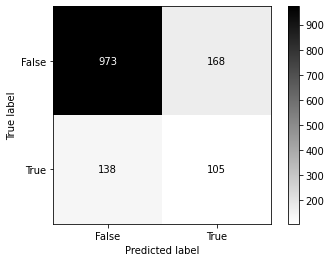

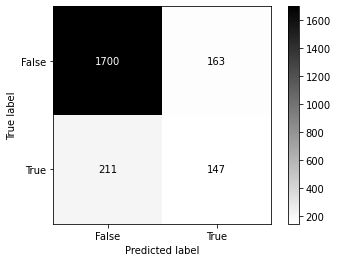

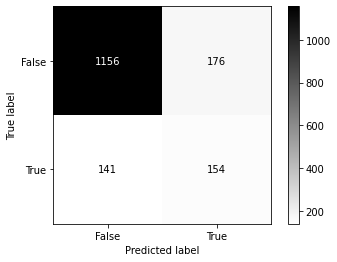

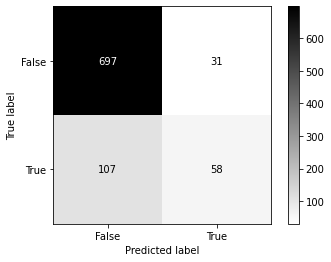

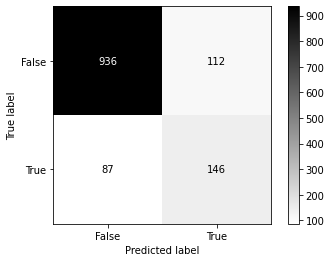

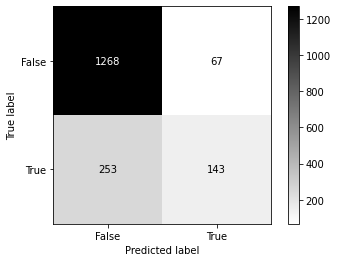

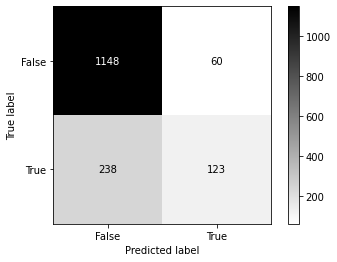

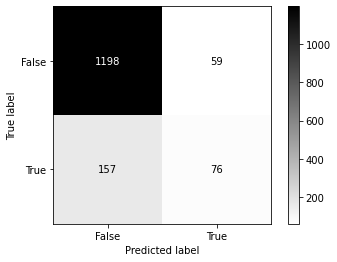

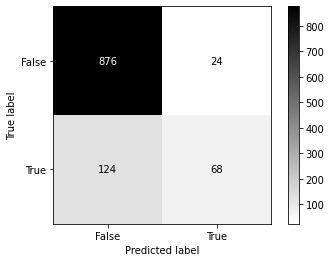

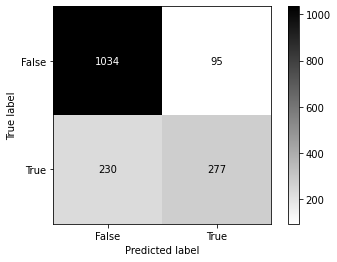

In [97]:
par_ens_scores, par_ens_dict = model_utils.get_report_from_splits(full_par_db,"par")

In [98]:
par_ens_scores

[0.7838563298844815,
 0.826628209198503,
 0.8093213780482132,
 0.8261783955318779,
 0.8476698523586471,
 0.7927852438914719,
 0.7855135037897657,
 0.8384504683329528,
 0.84417435788822,
 0.7916931694734353]

In [99]:
np.mean(par_ens_scores)

0.8146270908397568